In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import MonthLocator, DateFormatter

# Configs

In [3]:
INPUT_PATH = 'data/labels.parquet'

# Load Data

In [73]:
labels_df = pd.read_parquet(INPUT_PATH)
print(f'labels_df shape is {labels_df.shape}')
labels_df.head()

labels_df shape is (251520, 4)


,Location,Date,Time,Demand
0,1,2023-01-01,0-3,0
1,1,2023-01-01,3-6,1
2,1,2023-01-01,6-9,1
3,1,2023-01-01,9-12,4
4,1,2023-01-01,12-15,18


# General Info

## Finding Important Locations

In [27]:
def plot_cumsum_demand(labeled_df, target_demand):
    grouped_df = labeled_df.groupby('Location')['Demand'].sum().reset_index().sort_values(by='Demand', ascending=False).reset_index()
    cumulative_demand = (grouped_df['Demand'].cumsum() / grouped_df['Demand'].sum()).to_numpy()

    plt.plot(range(1,263), cumulative_demand)
    plt.xlabel('Location numbers')
    plt.ylabel('Cumulative Demand')
    plt.title('Cumulative Demand by Location')
    target_x = (cumulative_demand <= target_demand).argmin()
    plt.axhline(y=target_demand, color='r', linestyle='--', label=f'Target Demand ({target_demand})')
    plt.axvline(x=target_x, color='g', linestyle='--', label=f'Target Location ({target_x})')

    plt.legend() 
    plt.show()
    important_locations = grouped_df.iloc[:target_x, grouped_df.columns.get_loc('Location')]
    important_locations = important_locations.to_numpy()
    return important_locations

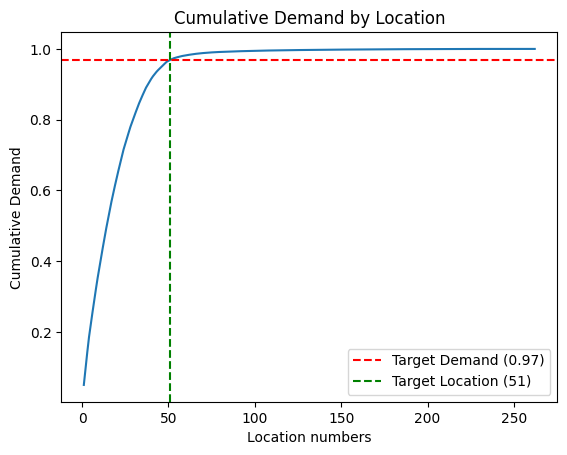

In [158]:
important_locations = plot_cumsum_demand(labels_df, 0.97)

# Visualization

## Visualize Location Demands

In [53]:
def visualize_locations(data_df, location_ids):
    colors = {'midnight': 'red', 'morning': 'blue', 'noon': 'green', 'night': 'purple'}

    fig, axes = plt.subplots(nrows=len(location_ids) // 2 + 1, ncols=2, figsize=(20,140))
    for i, ax in enumerate(axes.flat):
        try:
            location_df = data_df[data_df['Location'] == location_ids[i]]
        except IndexError:
            continue

        for time, color in colors.items():
            time_df = location_df[location_df['Time'] == time]
            ax.scatter(time_df['Date'], time_df['Demand'], color=color, s=15 ,label=time)

        ax.set_xlabel('Date')
        ax.set_ylabel('Demand')
        ax.set_title('Location ' + str(location_ids[i]))
        ax.legend(fontsize=10)


        month_locator = MonthLocator()
        ax.xaxis.set_major_locator(month_locator)
        date_formatter = DateFormatter('%Y-%m')
        ax.xaxis.set_major_formatter(date_formatter)
    plt.xticks(rotation=45)

    plt.show()

In [ ]:
visualize_locations(labels_df, important_locations)

## Importance of Times

## For All Data

<BarContainer object of 8 artists>

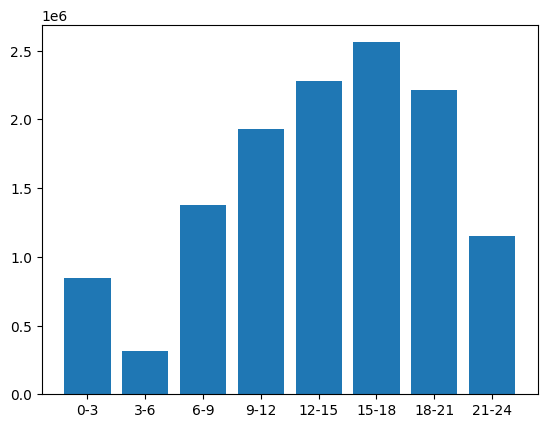

In [74]:
plt.bar(labels_df['Time'].unique(), labels_df.groupby('Time')['Demand'].sum())

## For Each Location

In [75]:
def importance_of_time_for_locations(data_df, location_ids):

    fig, axes = plt.subplots(nrows=len(location_ids) // 2 + 1, ncols=2, figsize=(20,140))
    for i, ax in enumerate(axes.flat):
        try:
            location_df = data_df[data_df['Location'] == location_ids[i]]
        except IndexError:
            continue

        ax.bar(location_df['Time'].unique(), location_df.groupby('Time')['Demand'].sum())
        ax.set_ylabel('Demand')
        ax.set_xlabel('Time')
        ax.set_title('Location ' + str(location_ids[i]))
    plt.show()


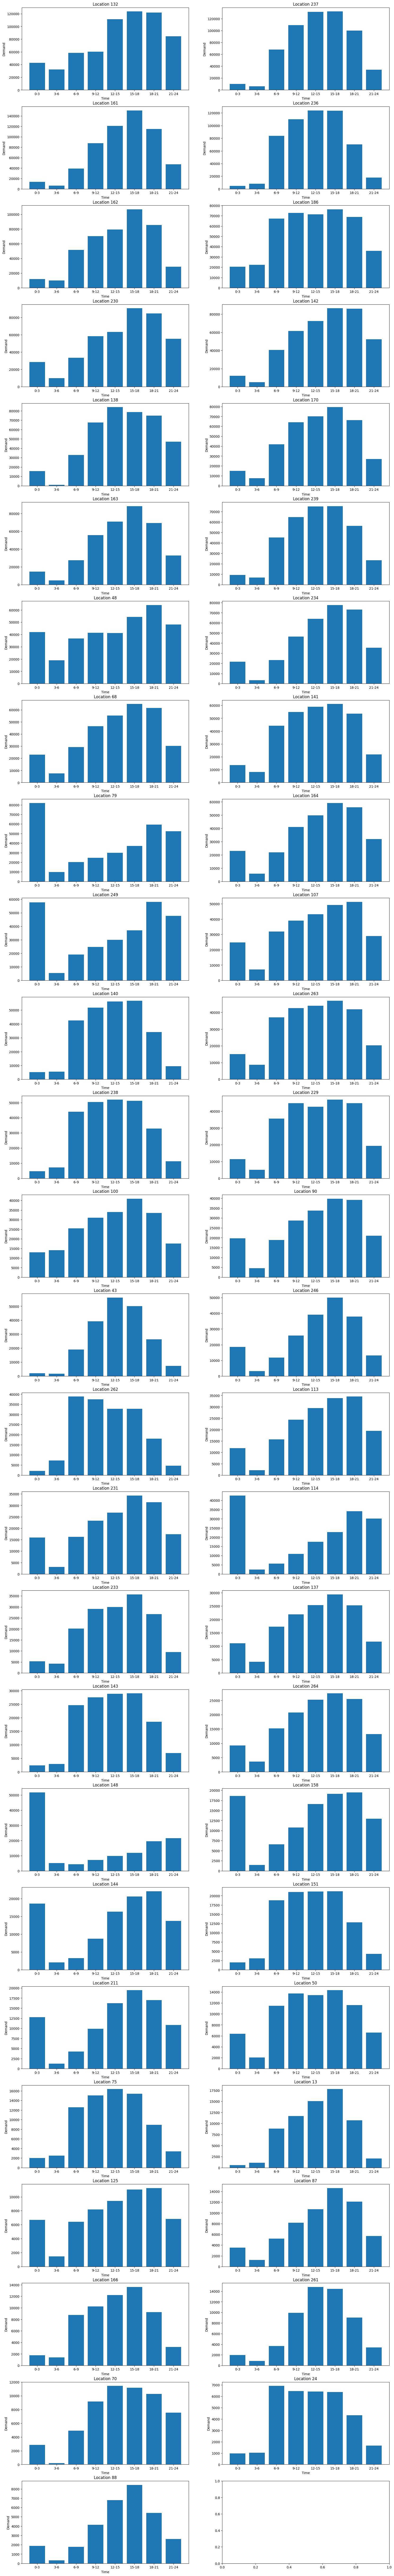

In [76]:
importance_of_time_for_locations(labels_df, important_locations)

In [178]:
def importance_of_time_for_dates_per_location(data_df, location_id):

    fig, axes = plt.subplots(nrows=15, ncols=2, figsize=(20,140))
    for i, ax in enumerate(axes.flat):
        try:
            location_df = data_df[(data_df['Location'] == location_id) & (data_df['Date'].dt.day == i + 1) & (data_df['Date'].dt.month == 3)]
        except IndexError:
            continue
        ax.bar(location_df['Time'].unique(), location_df.groupby('Time')['Demand'].sum())
        ax.set_ylabel('Demand')
        ax.set_xlabel('Time')
        ax.set_title('Day ' + str(i + 1))
    plt.show()


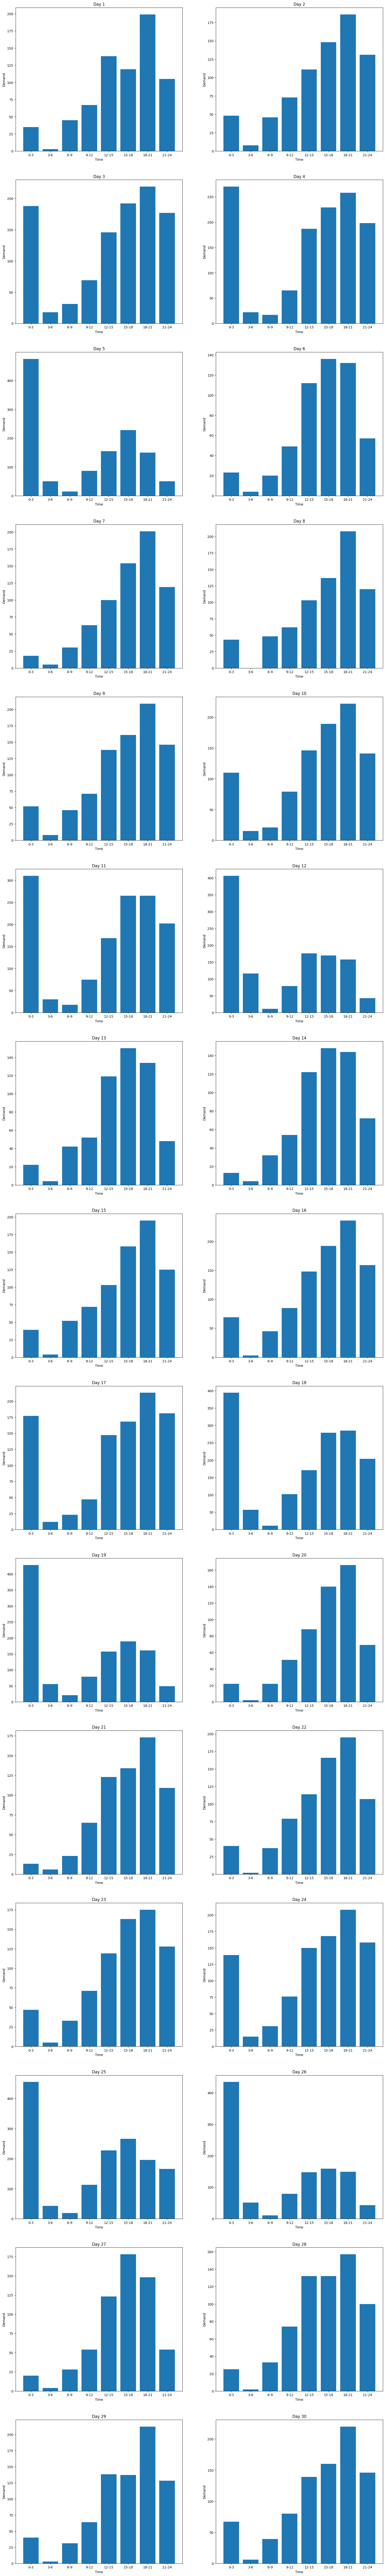

In [179]:
importance_of_time_for_dates_per_location(labels_df, 144)# 148, 114

In [128]:
ind_low_demand_loc = labels_df.groupby(['Location', 'Time'])['Demand'].min()==0
low_demand_location = ind_low_demand_loc[ind_low_demand_loc==True].index

## Checking Data Is Non-zero

In [159]:
zero_important_locations = []
for index, important_location in enumerate(important_locations):
    if important_location in list(set([index[0] for index in low_demand_location])):
        zero_important_locations.append((important_location, index))
zero_important_locations

[(144, 38), (13, 43), (261, 47), (70, 48), (24, 49), (88, 50)]

In [177]:
labels_df[labels_df[labels_df['Location'] == 144].eq(0)]['Demand'].dropna()
labels_df.iloc[134929]

Location                    144
Date        2023-03-08 00:00:00
Time                        3-6
Demand                        0
Name: 134929, dtype: object

In [163]:
labels_df[labels_df['Location'] == 88].eq(0)

Location     0
Date         0
Time         0
Demand      11
dtype: int64